# 13. 그리드 서치

In [10]:
library(tidyverse)
library(tidymodels)
tidymodels_prefer()

library(ggforce)
library(av)
library(lme4)
data(cells)
theme_set(theme_bw())

# 
# 
## 13.1 정규 및 비정규 그리드
- 그리드에는 두 가지 주요 유형이 존재 : 
    - 일반 그리드는 각 매개변수(해당 가능한 값 집합과)를 요인적으로 결합. 즉, 집합의 모든 조합을 사용
    - 비정규 그리드는 모수 조합이 작은 점 집합에서 형성되지 않는 그리드

# 

- 다층 퍼셉트론 모델의 튜닝을 위해 표시된 파라미터는 다음과 같음 :
    - 숨겨진 유닛의 수 
    - 모델 훈련에서의 적합 기간/반복 횟수 
    - 가중치 감소 페널티 크기
    
- 에폭스의 수는 조기 중지에 의해 결정
- 별도의 검증 세트는 훈련 세트를 다시 예측하여 과적합으로 이어졌기 때문에 오류율을 기반으로 훈련 기간을 결정
- 가중치 감소 패널티를 사용하면 과적합이 방지되어야 하며 패널티와 에폭 수를 조정하는 데 거의 해가 없음

# 

- ```trace = 0```은 훈련 프로세스의 추가 로깅을 방지
- ```extract_parameter_set_dials()```함수는 알 수 없는 값을 가진 파라미터 집합을 추출하고, 다이얼 객체를 설정 가능

In [11]:
mlp_spec <- mlp(hidden_units = tune(), penalty = tune(), epochs = tune()) %>%
    set_engine("nnet", trace = 0) %>%
    set_mode("classification")

In [13]:
mlp_param <- extract_parameter_set_dials(mlp_spec)
mlp_param %>% print

Collection of 3 parameters for tuning

   identifier         type    object
 hidden_units hidden_units nparam[+]
      penalty      penalty nparam[+]
       epochs       epochs nparam[+]



In [14]:
mlp_param %>% extract_parameter_dials("hidden_units") %>% print

# Hidden Units (quantitative)
Range: [1, 10]


In [15]:
mlp_param %>% extract_parameter_dials("penalty") %>% print

Amount of Regularization (quantitative)
Transformer: log-10 [1e-100, Inf]
Range (transformed scale): [-10, 0]


In [17]:
mlp_param %>% extract_parameter_dials("epochs") %>% print

# Epochs (quantitative)
Range: [10, 1000]


# 
# 
# 
### 정규 그리드

### ```crossing()```

- 정규 그리드는 별도의 매개변수 값 집합의 조합
    - 각 매개 변수에 대해 고유한 값 집합을 생성 => 가능한 값의 수는 각 모수에 대해 동일할 필요는 없음
    - ```crossing()```은 정규 격자를 만드는 한 방법


In [18]:
crossing(hidden_units = 1:3,
         penalty = c(0.0, 0.1),
         epochs = c(100, 200)) 

hidden_units,penalty,epochs
<int>,<dbl>,<dbl>
1,0.0,100
1,0.0,200
1,0.1,100
1,0.1,200
2,0.0,100
2,0.0,200
2,0.1,100
2,0.1,200
3,0.0,100


# 
### ```grid_*()``` : 다른 유형의 그리드를 생성하기 위해 매개 변수 객체를 입력으로 사용
- ```levels``` : 파라미터당 level 수

In [26]:
mlp_param %>%
    grid_regular(levels = c(hidden_units = 3, penalty = 2, epochs = 2)) %>% print

# A tibble: 12 x 3
   hidden_units      penalty epochs
          <int>        <dbl>  <int>
 1            1 0.0000000001     10
 2            5 0.0000000001     10
 3           10 0.0000000001     10
 4            1 1                10
 5            5 1                10
 6           10 1                10
 7            1 0.0000000001   1000
 8            5 0.0000000001   1000
 9           10 0.0000000001   1000
10            1 1              1000
11            5 1              1000
12           10 1              1000


# 
# 
- 정규 그리드는 특히 중간에서 큰 수의 튜닝 매개 변수가 있는 경우 사용하기에 계산적으로 비용이 많이 들 수 있음. 
- **정규 그리드를 사용하는 것의 한 가지 이점은 조정 파라미터와, 모델 메트릭 사이의 관계와 패턴을 쉽게 이해할 수 있다는 것**
    - 이러한 설계의 요인 특성으로 인해 모수 간의 상호작용 없이 각 모수를 개별적으로 검사할 수 있음


# 
# 
# 
### 비정규 그리드
- 비정규 그리드를 생성하기 위한 몇 가지 옵션 : 
    - 첫 번째는 파라미터 범위에 걸쳐 무작위 샘플링을 사용하는 것 
        - ```grid_random()``` : 파라미터 범위에 걸쳐 독립적인 균일한 난수를 생성
        - 파라미터에 관련된 변환(예: 패널티에 대한 변환)이 있는 경우 변환된 척도에서 난수가 생성

# 

### ```grid_random()```

In [27]:
set.seed(1301) 
mlp_param %>% grid_random(size = 1000) %>% summary

  hidden_units       penalty              epochs     
 Min.   : 1.000   Min.   :0.0000000   Min.   : 10.0  
 1st Qu.: 3.000   1st Qu.:0.0000000   1st Qu.:265.8  
 Median : 5.000   Median :0.0000061   Median :497.0  
 Mean   : 5.381   Mean   :0.0437435   Mean   :509.5  
 3rd Qu.: 8.000   3rd Qu.:0.0026854   3rd Qu.:761.0  
 Max.   :10.000   Max.   :0.9814405   Max.   :999.0  

- 랜덤 그리드의 문제는 중소형 그리드의 경우 **랜덤 값이 매개 파라미터 조합을 겹치게 할 수 있다는 것**. 
- 랜덤 그리드는 전체 파라미터 공간을 커버해야 하지만 그리드 값의 수에 따라 커버리지가 잘 될 가능성이 증감



# 
- 무작위로 생성된 15개의 포인트를 가진 3개의 튜닝 파라미터
(```original = FALSE``` : penalty를 log10 단위로 유지)


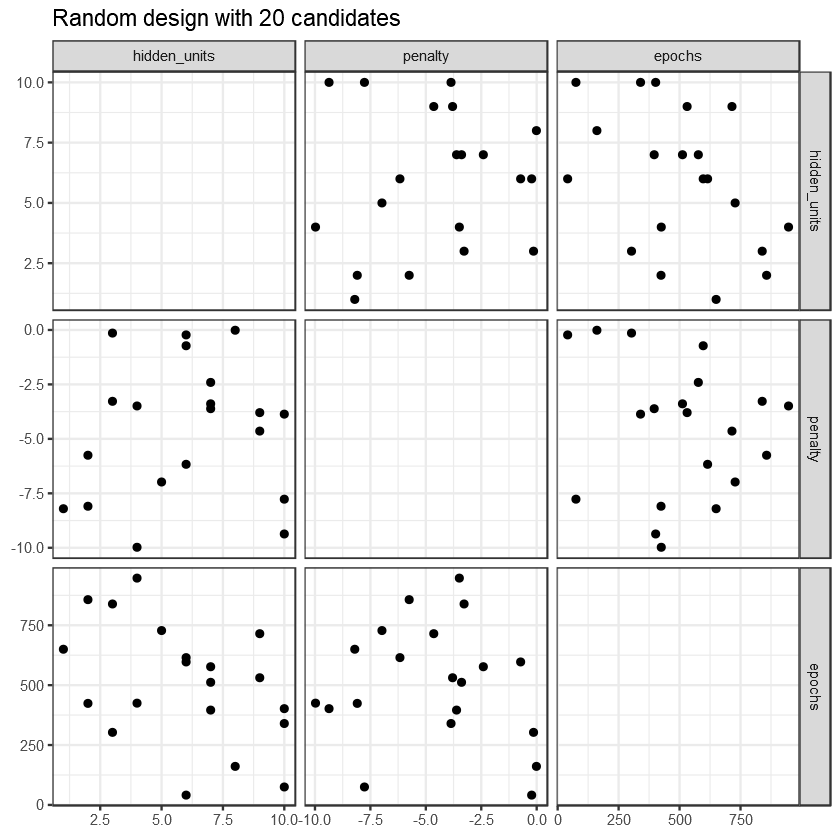

In [30]:
set.seed(1302)
mlp_param %>% grid_random(size = 20, original = FALSE) %>% 
    ggplot(aes(x = .panel_x, y = .panel_y)) + 
    geom_point() +
    geom_blank() +
    facet_matrix(vars(hidden_units, penalty, epochs), layer.diag = 2) + 
    labs(title = "Random design with 20 candidates")

# 
- '공간 채우기 설계'라는 실험 설계 세트 : 
    - 설계 방법마다 약간 다른 목표가 있지만 일반적으로 중복되거나 중복되는 값이 가장 작은 모수 공간을 포함하는 점 구성을 탐색

- 다이얼 패키지에는 '라틴 하이퍼큐브' 및 '최대 엔트로피 설계'에 대한 함수가 포함
- '라틴 하이퍼큐브 설계'는 점들을 서로 더 멀리 띄우고 하이퍼 파라미터 공간에 대한 더 나은 탐색을 가능하게 함
- '공간 채우기 설계'는 모수 공간을 표현하는 데 매우 효과적. 

# 

- 튜닝 패키지에 사용되는 다른 설계 방법은 '최대 엔트로피 설계' : 
    - 공간을 잘 커버하는 그리드를 생산하는 경향이 있고 좋은 결과를 찾을 기회를 획기적으로 증가시킴.


# 

### ```grid_latin_hypercube()```
### ```grid_max_entropy()```

# 

- 공간 채우기 설계를 사용하여 생성된 20개의 점이 있는 세 개의 튜닝 매개 변수

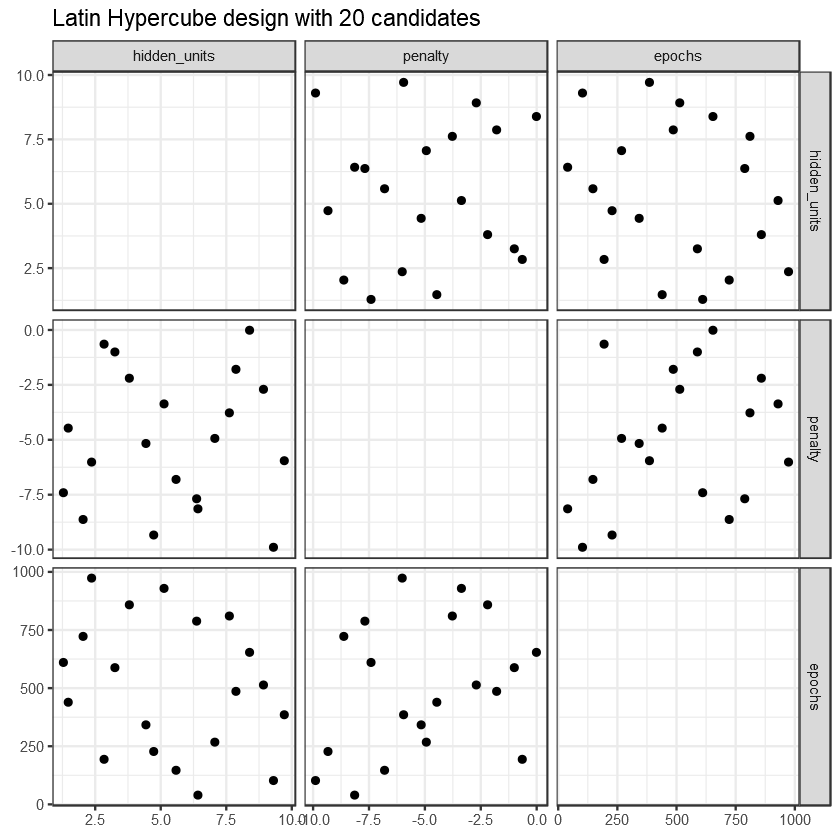

In [31]:
set.seed(1303)
mlp_param %>% grid_latin_hypercube(size = 20, original = FALSE) %>% 
    ggplot(aes(x = .panel_x, y = .panel_y)) + 
    geom_point() +
    geom_blank() +
    facet_matrix(vars(hidden_units, penalty, epochs), layer.diag = 2) + 
    labs(title = "Latin Hypercube design with 20 candidates")

# 
# 
# 
## 13.2 그리드 평가
- 최적의 파라미터 조합을 선택하기 위해 각 후보 집합은 해당 모형을 훈련하는 데 사용되지 않은 데이터를 사용하여 평가. 
- 리샘플링 방법 또는 단일 검증 집합은 이 목적에 적합

- 리샘플링 후, 가장 적합한 후보 파라미터 세트를 선택. 경험적으로 최상의 모수 조합을 선택하거나 단순성과 같은 모델 적합의 다른 측면으로 선택을 편향시키는 것이 타당





In [33]:
cells %>%  select(-case) -> cells

In [34]:
set.seed(1304)
cell_folds <- vfold_cv(cells)

- 예측 변수 간의 상관 관계가 높기에, PCA 기능 추출을 사용하여 예측 변수의 관계를 재정립
- **PCA는 분산 기반이므로 이상치는 계산에 악영향을 미칠 수 있음**.
    - 이에 각 예측 변수에 대한 Yeo-Johnson 변환을 추정하는 레시피 단계를 추가
    - ```step_YeoJohnson()```은 초기 정규화 직전에 ```step_normalize()```를 통해 레시피에서 사용
    
- step_pca()에서 0개의 PCA 구성 요소를 사용하는 것이 변수 추출을 건너뛸 수 있는 방법
- 이러한 방식으로 원래 예측 변수는 PCA 구성 요소를 포함하는 결과와 직접 비교할 수 있음

In [35]:
mlp_rec <- recipe(class ~ ., data = cells) %>%
    step_YeoJohnson(all_numeric_predictors()) %>% 
    step_normalize(all_numeric_predictors()) %>% 
    step_pca(all_numeric_predictors(), num_comp = tune()) %>% 
    step_normalize(all_numeric_predictors())

In [36]:
mlp_wflow <- workflow() %>% 
    add_model(mlp_spec) %>% 
    add_recipe(mlp_rec)

- 매개 변수 개체 mlp_param을 생성하여 몇 가지 기본 범위를 조정
- 더 작은 범위(50 ~ 200 epoch)를 가지도록 epoch의 수를 변경
- ```num_comp()```의 기본 범위는 매우 좁은 범위(1~4개의 구성 요소). 이 범위를 40개의 구성 요소로 늘리고 최소값을 0으로 설정



In [37]:
mlp_param <- mlp_wflow %>% 
    extract_parameter_set_dials() %>% 
    update(
        epochs = epochs(c(50, 200)),
        num_comp = num_comp(c(0, 40)))

In [38]:
mlp_param %>% print

Collection of 4 parameters for tuning

   identifier         type    object
 hidden_units hidden_units nparam[+]
      penalty      penalty nparam[+]
       epochs       epochs nparam[+]
     num_comp     num_comp nparam[+]



# 
# 
### ```tune_grid()``` : 그리드 서치를 수행하기 위한 주요 함수
- ```grid``` : 정수 또는 데이터 프레임입니다. 정수가 사용되는 경우 함수는 후보 파라미터 조합의 그리드 번호를 사용하여 공간 채우기 설계를 생성. 특정 파라미터 조합이 존재하는 경우 그리드 파라미터는 함수에 전달하는 데 사용
- ```param_info``` :  파라미터 범위를 정의하기 위한 선택적 인수. 인수는 그리드가 정수일 때 가장 유용

# 

- ```tune_grid()```에 대한 인터페이스는 ```fit_resamples()```와 동일 :
    - 첫 번째 인수는 모델 사양 또는 워크플로우. 
    - 모델이 주어졌을 때, 두 번째 인수는 레시피 또는 공식
    - 또 다른 필수 인수는 rsample 재샘플링 객체(예: cell_folds)





In [39]:
roc_res <- metric_set(roc_auc)

In [40]:
set.seed(1305)
mlp_reg_tune <- mlp_wflow %>%
    tune_grid(cell_folds,
              grid = mlp_param %>% grid_regular(levels = 3),
              metrics = roc_res)

In [41]:
mlp_reg_tune %>% print

# Tuning results
# 10-fold cross-validation 
# A tibble: 10 x 4
   splits             id     .metrics          .notes          
   <list>             <chr>  <list>            <list>          
 1 <split [1817/202]> Fold01 <tibble [81 x 8]> <tibble [0 x 3]>
 2 <split [1817/202]> Fold02 <tibble [81 x 8]> <tibble [0 x 3]>
 3 <split [1817/202]> Fold03 <tibble [81 x 8]> <tibble [0 x 3]>
 4 <split [1817/202]> Fold04 <tibble [81 x 8]> <tibble [0 x 3]>
 5 <split [1817/202]> Fold05 <tibble [81 x 8]> <tibble [0 x 3]>
 6 <split [1817/202]> Fold06 <tibble [81 x 8]> <tibble [0 x 3]>
 7 <split [1817/202]> Fold07 <tibble [81 x 8]> <tibble [0 x 3]>
 8 <split [1817/202]> Fold08 <tibble [81 x 8]> <tibble [0 x 3]>
 9 <split [1817/202]> Fold09 <tibble [81 x 8]> <tibble [0 x 3]>
10 <split [1818/201]> Fold10 <tibble [81 x 8]> <tibble [0 x 3]>


- 정규 그리드 결과

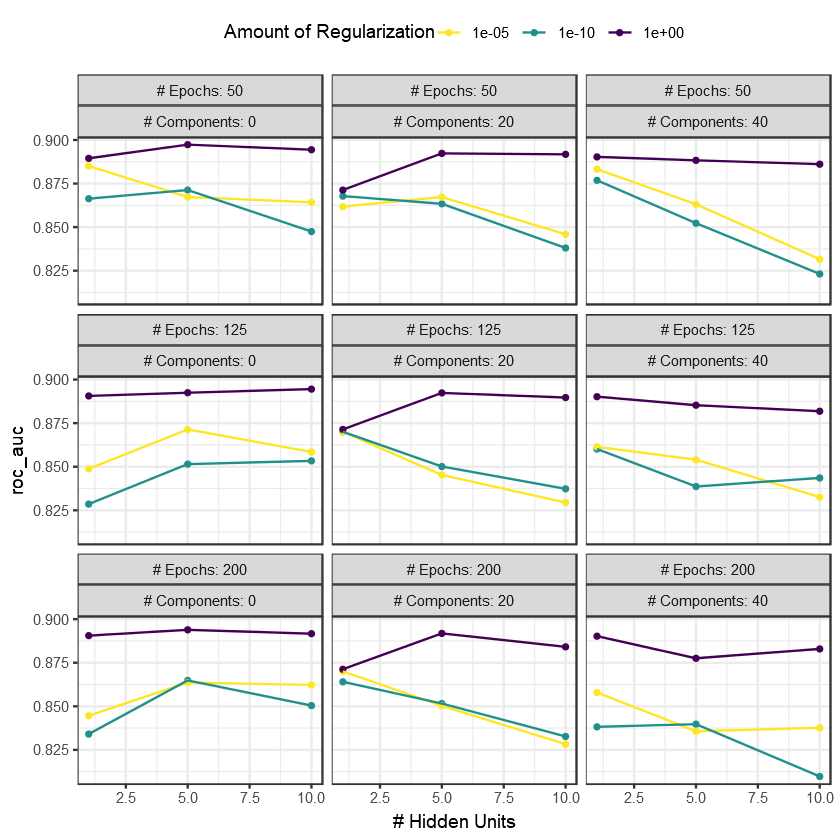

In [42]:
autoplot(mlp_reg_tune) + 
    scale_color_viridis_d(direction = -1) + 
    theme(legend.position = "top")

- penalty의 크기가 ROC 곡선 아래의 영역에 가장 큰 영향을 미침을 확인. 
- epoch의 수는 성능에 뚜렷한 영향을 미치지 않는 것으로 보임을 확인. 
- 은닉층의 수의 변화는 정규화의 양이 적을 때(그리고 성능을 해칠 때) 가장 중요한 것으로 보임. 

# 
# 
### ```show_best()```


In [44]:
show_best(mlp_reg_tune) %>% select(-.estimator)

hidden_units,penalty,epochs,num_comp,.metric,mean,n,std_err,.config
<int>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,1,50,0,roc_auc,0.8973350,10,0.008572016,Preprocessor1_Model08
10,1,125,0,roc_auc,0.8945163,10,0.008984984,Preprocessor1_Model18
10,1,50,0,roc_auc,0.8944248,10,0.009602143,Preprocessor1_Model09
5,1,200,0,roc_auc,0.8938910,10,0.007843445,Preprocessor1_Model26
5,1,125,0,roc_auc,0.8924622,10,0.008224695,Preprocessor1_Model17


- 결과를 바탕으로 가중치 감소 패널티 값을 통해, 더 큰 그리드 서치를 다시 수행하는 것이 타당
- '공간 채우기 설계'를 사용하기 위해 그리드 인수는 정수가 주어지거나 ```grid_*()``` 함수 중 하나가 데이터 프레임을 생성할 수 있음. 

# 

- 후보 값이 20개인 '최대 엔트로피 설계'를 사용하여 동일한 범위를 평가 :



In [43]:
set.seed(1306)
mlp_sfd_tune <- mlp_wflow %>%
    tune_grid(cell_folds,    
              grid = 20, 
              param_info = mlp_param, 
              metrics = roc_res)

In [45]:
mlp_sfd_tune %>% print

# Tuning results
# 10-fold cross-validation 
# A tibble: 10 x 4
   splits             id     .metrics          .notes          
   <list>             <chr>  <list>            <list>          
 1 <split [1817/202]> Fold01 <tibble [20 x 8]> <tibble [0 x 3]>
 2 <split [1817/202]> Fold02 <tibble [20 x 8]> <tibble [0 x 3]>
 3 <split [1817/202]> Fold03 <tibble [20 x 8]> <tibble [0 x 3]>
 4 <split [1817/202]> Fold04 <tibble [20 x 8]> <tibble [0 x 3]>
 5 <split [1817/202]> Fold05 <tibble [20 x 8]> <tibble [0 x 3]>
 6 <split [1817/202]> Fold06 <tibble [20 x 8]> <tibble [0 x 3]>
 7 <split [1817/202]> Fold07 <tibble [20 x 8]> <tibble [0 x 3]>
 8 <split [1817/202]> Fold08 <tibble [20 x 8]> <tibble [0 x 3]>
 9 <split [1817/202]> Fold09 <tibble [20 x 8]> <tibble [0 x 3]>
10 <split [1818/201]> Fold10 <tibble [20 x 8]> <tibble [0 x 3]>


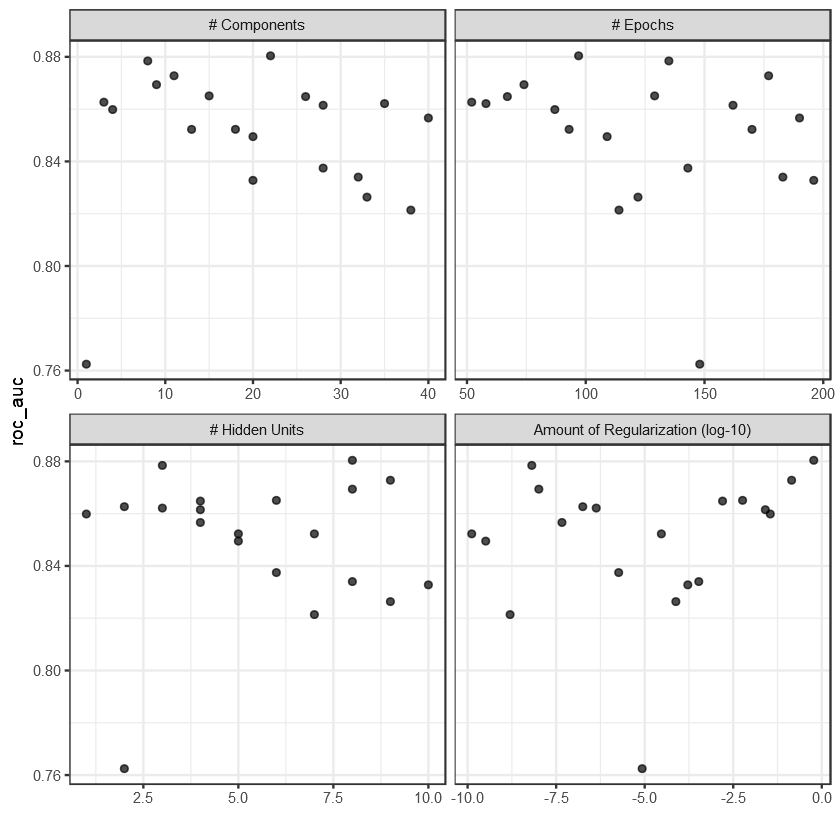

In [46]:
autoplot(mlp_sfd_tune)

- 패널티 파라미터는 더 적은 양의 가중치 감소로 더 나은 성능을 제공하는 것으로 보임. **이는 정규 그리드의 결과와는 반대**
- **각 패널의 각 점은 다른 세 개의 조정 파라미터와 공유되므로 한 패널의 추세는 다른 패널의 영향을 받을 수 있음**
- 정규 그리드를 사용하면 각 패널의 각 점이 다른 파라미터에 대해 동일하게 평균화 됨. 이러한 이유로, 각 파라미터의 효과는 일반 그리드로 더 잘 분리됨

In [48]:
show_best(mlp_sfd_tune) %>% select(-.estimator) 

hidden_units,penalty,epochs,num_comp,.metric,mean,n,std_err,.config
<int>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,5.940130e-01,97,22,roc_auc,0.8804158,10,0.009984549,Preprocessor16_Model1
3,6.487197e-09,135,8,roc_auc,0.8784611,10,0.009551410,Preprocessor13_Model1
9,1.407762e-01,177,11,roc_auc,0.8727865,10,0.010380857,Preprocessor03_Model1
8,1.026357e-08,74,9,roc_auc,0.8693823,10,0.007608284,Preprocessor10_Model1
6,5.814140e-03,129,15,roc_auc,0.8650925,10,0.006581221,Preprocessor17_Model1


# 
# 
# 

- 일반적으로 여러 메트릭에 걸쳐 모형을 평가하여 모형 적합의 다양한 측면이 고려되도록 하는 것이 지향.
- ```fit_resamples()```의 결과와 마찬가지로, 일반적으로 리샘플링과 파라미터 튜닝에서 중간 모델 적합을 유지하는 데에는 아무런 가치가 없습니다. 그러나 이전과 마찬가지로 ```control_grid()```에 대한 추출 옵션을 사용하면 적합된 모델 및/또는 레시피를 유지할 수 있음. 
    - ```save_pred``` 옵션을 ```TRUE```로 설정하면 평가 세트 예측이 유지되며 ```collect_predictions()```를 사용하여 이러한 예측에 활용 가능

# 
# 
# 
## 13.3 최종 모형 결정
- 최종 모형을 적합시키려면 모수 값의 최종 집합을 결정 :
    - 1. 적절한 것으로 보이는 값을 수동으로 선택
    - 2. ```select_*()``` 함수를 사용

### ```select_*()```
- ```select_best()``` : 수치적으로 가장 좋은 결과를 가진 파라미터를 선택



In [49]:
select_best(mlp_reg_tune, metric = "roc_auc")

hidden_units,penalty,epochs,num_comp,.config
<int>,<dbl>,<int>,<int>,<chr>
5,1,50,0,Preprocessor1_Model08


In [57]:
logistic_param <- tibble(num_comp = 0,
                         epochs = 50, 
                         hidden_units = 5,
                         penalty = 1)

In [58]:
final_mlp_wflow <- mlp_wflow %>%
    finalize_workflow(logistic_param)

In [59]:
final_mlp_wflow %>% print

== Workflow ============================================================================================================
Preprocessor: Recipe
Model: mlp()

-- Preprocessor --------------------------------------------------------------------------------------------------------
4 Recipe Steps

* step_YeoJohnson()
* step_normalize()
* step_pca()
* step_normalize()

-- Model ---------------------------------------------------------------------------------------------------------------
Single Layer Neural Network Model Specification (classification)

Main Arguments:
  hidden_units = 5
  penalty = 1
  epochs = 50

Engine-Specific Arguments:
  trace = 0

Computational engine: nnet 



In [60]:
final_mlp_fit <- final_mlp_wflow %>% fit(cells)

# 
# 
- 워크플로우를 사용하지 않은 경우 모델 및/또는 레시피의 최종화는 ```finalize_model()``` 및 ```finalize_recipe()```를 사용


# 
# 
# 
## 13.4 튜닝 사양 작성 도구
- use models 패키지는 데이터 프레임과 모델 공식을 취한 다음 모델을 튜닝하기 위한 R 코드를 작성
- 이 코드는 요청된 모형과 예측 변수 데이터에 따라 단계가 달라지는 적절한 방법을 생성합니다.



In [61]:
library(usemodels)

In [63]:
data(ames)
ames <- mutate(ames, Sale_Price = log10(Sale_Price))

set.seed(502)
ames_split <- initial_split(ames, prop = 0.80, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test  <-  testing(ames_split)

In [64]:
use_xgboost(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude, 
            data = ames_train,
            verbose = TRUE)

xgboost_recipe <- 
  recipe(formula = Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
    Latitude + Longitude, data = ames_train) %>% 
  step_novel(all_nominal_predictors()) %>% 
  ## This model requires the predictors to be numeric. The most common 
  ## method to convert qualitative predictors to numeric is to create 
  ## binary indicator variables (aka dummy variables) from these 
  ## predictors. However, for this model, binary indicator variables can be 
  ## made for each of the levels of the factors (known as 'one-hot 
  ## encoding'). 
  step_dummy(all_nominal_predictors(), one_hot = TRUE) %>% 
  step_zv(all_predictors()) 

xgboost_spec <- 
  boost_tree(trees = tune(), min_n = tune(), tree_depth = tune(), learn_rate = tune(), 
    loss_reduction = tune(), sample_size = tune()) %>% 
  set_mode("regression") %>% 
  set_engine("xgboost") 

xgboost_workflow <- 
  workflow() %>% 
  add_recipe(xgboost_recipe) %>% 
  add_model(xgboost_spec) 

set.seed(7019)
xgboo

- 위의 결과코드는 **필요한 최소한의 전처리**

# 
# 
# 
## 13.5 효율적인 그리드 서치

### 하위 모델 최적화

- 단일 모델 적합에서, 적합하지 않고도 여러 튜닝 파라미터를 평가할 수 있는 모델 유형이 존재.

# 

- 부분 최소 제곱(PLS)은 주성분 분석의 지도학습 버전
- 변수(예: PCA)의 변동을 최대화하는 성분을 생성하지만 이러한 예측 변수와 결과 간의 상관 관계를 최대화하려고 시도
- 한 가지 조정 매개 변수는 유지할 PLS 구성 요소의 수
- 변수가 100개인 데이터 집합이 PLS를 사용하여 적합하다고 가정 :
    - 유지할 수 있는 구성 요소의 수는 1개에서 50개까지
    - 그러나 많은 구현에서 단일 모델 적합은 num_comp의 많은 값에 걸쳐 예측 값을 계산할 수 있음. 
    - 결과적으로, 100개의 성분으로 생성된 PLS 모델은 또한 임의의 num_comp <= 100에 대한 예측을 할 수 있음. 
    - 중복 모형 적합치를 만드는 대신 단일 적합치를 사용하여 많은 하위 모형을 평가할 수 있으므로 시간이 절약

# 
- 부스팅 모델은 일반적으로 부스팅 반복 횟수에 대한 여러 값에 걸쳐 예측을 할 수 있음. 
- glmnet 모형과 같은 정규화 방법은 모형을 적합시키는 데 사용되는 정규화의 양에 걸쳐 동시 예측을 할 수 있음. 
- 다변량 적응 회귀 스플라인(MARS)은 선형 회귀 모형에 일련의 비선형 특징을 추가. 유지할 항 수는 튜닝 파라미터이며, 단일 모형 적합에서 이 파라미터의 많은 값에 걸쳐 예측하는 것이 계산적으로 빠름.



- 튜닝 패키지는 해당 모델이 튜닝될 때마다 이러한 유형의 최적화를 자동으로 적용
- 부스팅된 C5.0 분류 모델이 데이터에 적합했다면, 부스트 반복 횟수(트리)를 조정할 수 있음. 
- 다른 모든 파라미터를 기본값으로 설정하면 이전에 사용한 것과 동일한 리샘플링에서 1부터 100까지의 반복을 평가할 수 있음





In [ ]:
install.packagesckages("spark")

In [79]:
show_engines("boost_tree")

engine,mode
<chr>,<chr>
xgboost,classification
xgboost,regression
C5.0,classification
spark,classification
spark,regression


In [83]:
xgboost_spec <- boost_tree(trees = tune()) %>% 
    set_engine("xgboost") %>% 
    set_mode("classification")

In [84]:
set.seed(1307)
xgboost_spec %>% tune_grid(class ~ .,
                           resamples = cell_folds,
                           grid = data.frame(trees = 1:100),
                           metrics = roc_res) %>% print

# Tuning results
# 10-fold cross-validation 
# A tibble: 10 x 4
   splits             id     .metrics           .notes          
   <list>             <chr>  <list>             <list>          
 1 <split [1817/202]> Fold01 <tibble [100 x 5]> <tibble [0 x 3]>
 2 <split [1817/202]> Fold02 <tibble [100 x 5]> <tibble [0 x 3]>
 3 <split [1817/202]> Fold03 <tibble [100 x 5]> <tibble [0 x 3]>
 4 <split [1817/202]> Fold04 <tibble [100 x 5]> <tibble [0 x 3]>
 5 <split [1817/202]> Fold05 <tibble [100 x 5]> <tibble [0 x 3]>
 6 <split [1817/202]> Fold06 <tibble [100 x 5]> <tibble [0 x 3]>
 7 <split [1817/202]> Fold07 <tibble [100 x 5]> <tibble [0 x 3]>
 8 <split [1817/202]> Fold08 <tibble [100 x 5]> <tibble [0 x 3]>
 9 <split [1817/202]> Fold09 <tibble [100 x 5]> <tibble [0 x 3]>
10 <split [1818/201]> Fold10 <tibble [100 x 5]> <tibble [0 x 3]>


# 
# 
# 
### 전역변수에 대한 접근
- 모델 파라미터로 사용할 변수를 정의한 다음 ```linear_reg()```와 같은 함수에 전달하면 일반적으로 변수는 전역 환경에서 정의

In [85]:
coef_penalty <- 0.1
spec <- linear_reg(penalty = coef_penalty) %>% set_engine("glmnet")
spec

Linear Regression Model Specification (regression)

Main Arguments:
  penalty = coef_penalty

Computational engine: glmnet 


- parsnip 패키지를 사용하여 만든 모델은 다음과 같은 인수를 저장 : 객체의 이름과, 객체의 환경을 모두 추적


In [86]:
spec$args$penalty

<quosure>
expr: ^coef_penalty
env:  global

- parsnip 패키지를 사용하여 만든 모델은 다음과 같은 인수를 저장 : 객체의 이름과, 객체의 환경을 모두 추적


# 
- 이 변수는 글로벌 환경에서 생성되었기 때문에 ```env: global```
- 사용자의 일반 세션에서 실행할 때 해당 세션도 글로벌 환경을 사용하기 때문에, 사양에 의해 정의된 모델 사양이 올바르게 작동. R은 coef_penalty 객체를 쉽게 찾을 수 있음

# 

- 병렬로 실행될 코드를 작성할 때는, 객체에 대한 참조보다는 실제 데이터를 객체에 삽입하는 것이 좋음. 
- ```!! ```연산자는 단일 값을 객체에 분할할 수 있음

In [87]:
spec <- linear_reg(penalty = !!coef_penalty) %>% set_engine("glmnet")
spec$args$penalty

<quosure>
expr: ^0.1
env:  empty

- 이제 출력은 ^0.1로, 객체에 대한 참조 대신 값이 있음을 나타냄. 
- 개체에 삽입할 외부 값이 여러 개인 경우 ```!!!```는 다음을 도울 수 있음:


In [89]:
mcmc_args <- list(chains = 3, iter = 1000, cores = 3)
linear_reg() %>% set_engine("stan", !!!mcmc_args)

Linear Regression Model Specification (regression)

Engine-Specific Arguments:
  chains = 3
  iter = 1000
  cores = 3

Computational engine: stan 


# 
# 
- 레시피 선택기는 전역 변수에 액세스할 수 있는 또 다른 방법. 
- 데이터의 모든 변수를 사용해야 하는 레시피 단계가 있다고 가정 시, 다음과 같은 이름의 열을 생성


In [90]:
library(stringr)
ch_2_vars <- str_subset(names(cells), "ch_2")
ch_2_vars

[1] "avg_inten_ch_2"   "total_inten_ch_2"

In [91]:
recipe(class ~ ., data = cells) %>% 
    step_spatialsign(all_of(ch_2_vars))

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         56

Operations:

Spatial sign on  all_of(ch_2_vars)

In [92]:
recipe(class ~ ., data = cells) %>% 
    step_spatialsign(!!!ch_2_vars)

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         56

Operations:

Spatial sign on  "avg_inten_ch_2", "total_inten_ch_2"

# 
# 
# 
### Racing Method
- 그리드 서치의 한 가지 문제는 튜닝 파라미터를 평가하기 전에, 모든 모델이 모든 리샘플링에 적합해야 한다는 것 
- 튜닝 중 어느 시점에서 파라미터 후보를 제거하기 위해 중간 분석을 수행할 수 있다면, 도움이 될 것

# 

- **머신 러닝에서, Racing Method라고 불리는 일련의 기술은, 튜닝 프로세스중 리샘플링의 초기 하위 집합에 대해 모든 모델을 평가. 현재 성능 메트릭에 따라 일부 파라미터 집합은 후속 리샘플링에서 고려되지 않음**

# 

- 20개의 파라미터 튜닝과, 10개의 리샘플에 대한 Racing Method
- **모델의 결과는 단측 95% 신뢰 구간으로, 현재 가장 우수한 성능을 발휘하는 매개변수에 상대적인 ROC 값의 손실을 측정**


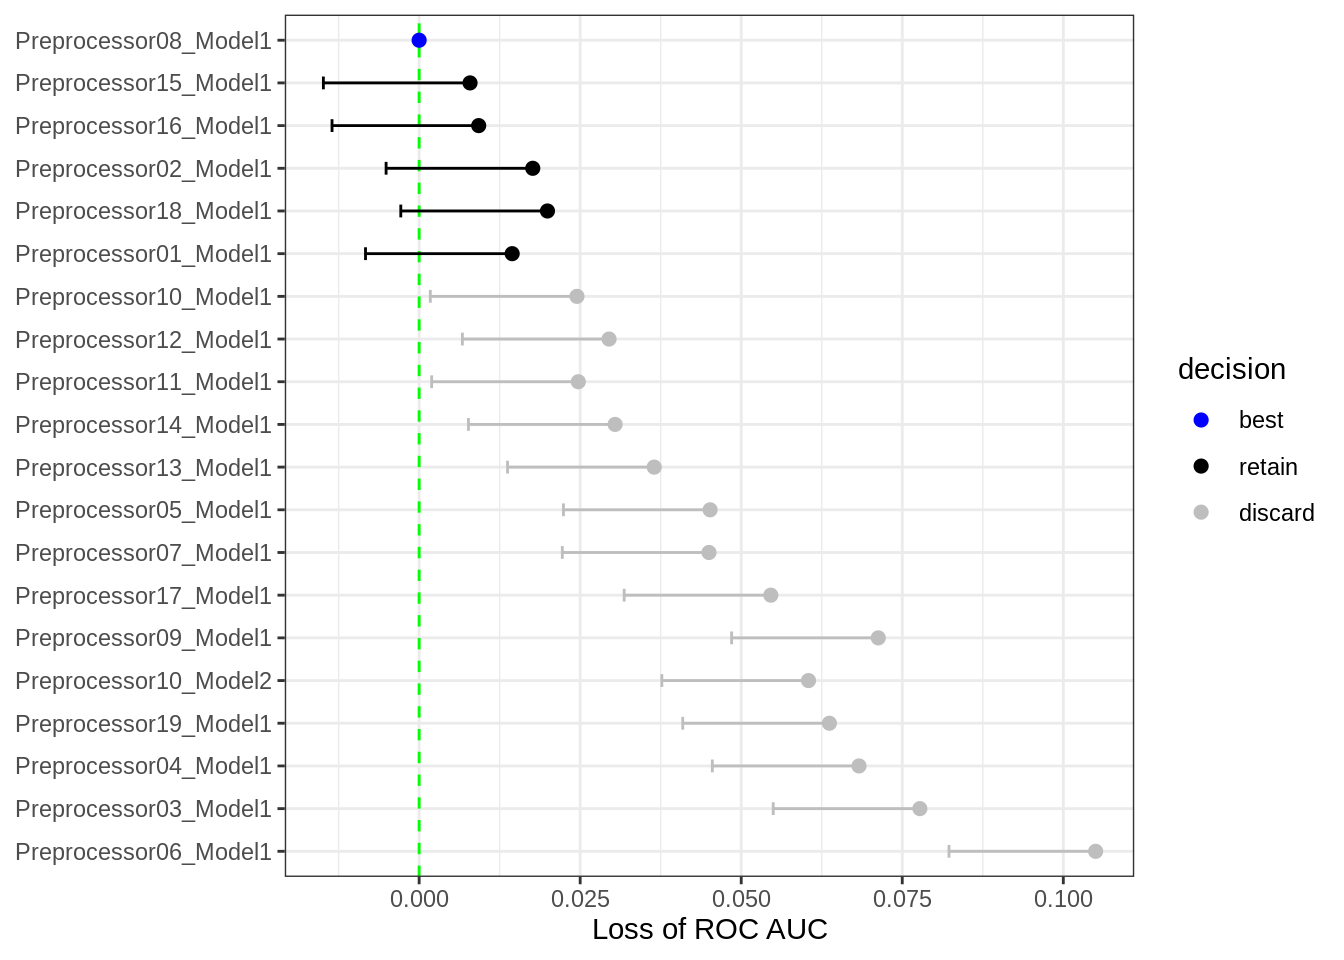


# 


https://www.tmwr.org/race_results.mp4





# 

- finetune 패키지에는 Racing Method가 포함

# 

### ```tune_race_anova()``` : 분산 분석 모형을 수행하여 서로 다른 모형 구성의 통계적 유의성을 검정
- 인수들은 ```tune_grid()```의 인수들과 유사

- ```control_race()``` 함수에는 제거 절차에 대한 옵션이 존재

 

In [94]:
library(finetune)

In [95]:
set.seed(1308)
mlp_sfd_race <- mlp_wflow %>%
    tune_race_anova(cell_folds,
                    grid = 20,
                    param_info = mlp_param,
                    metrics = roc_res, 
                    control = control_race(verbose_elim = TRUE))

i Racing will maximize the roc_auc metric.
i Resamples are analyzed in a random order.
i Fold10: 14 eliminated;  6 candidates remain.
i Fold06:  2 eliminated;  4 candidates remain.
i Fold08:  2 eliminated;  2 candidates remain.
i Fold09:  0 eliminated;  2 candidates remain.
i Fold05: All but one parameter combination were eliminated.


In [98]:
mlp_sfd_race %>% print

# Tuning results
# 10-fold cross-validation 
# A tibble: 10 x 5
   splits             id     .order .metrics          .notes          
   <list>             <chr>   <int> <list>            <list>          
 1 <split [1817/202]> Fold02      2 <tibble [20 x 8]> <tibble [0 x 3]>
 2 <split [1817/202]> Fold04      3 <tibble [20 x 8]> <tibble [0 x 3]>
 3 <split [1818/201]> Fold10      1 <tibble [20 x 8]> <tibble [0 x 3]>
 4 <split [1817/202]> Fold06      4 <tibble [6 x 8]>  <tibble [0 x 3]>
 5 <split [1817/202]> Fold08      5 <tibble [4 x 8]>  <tibble [0 x 3]>
 6 <split [1817/202]> Fold09      6 <tibble [2 x 8]>  <tibble [0 x 3]>
 7 <split [1817/202]> Fold05      7 <tibble [2 x 8]>  <tibble [0 x 3]>
 8 <split [1817/202]> Fold01      8 <tibble [1 x 8]>  <tibble [0 x 3]>
 9 <split [1817/202]> Fold03     10 <tibble [1 x 8]>  <tibble [0 x 3]>
10 <split [1817/202]> Fold07      9 <tibble [1 x 8]>  <tibble [0 x 3]>


In [99]:
show_best(mlp_sfd_race)

hidden_units,penalty,epochs,num_comp,.metric,.estimator,mean,n,std_err,.config
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,0.8139619,177,15,roc_auc,binary,0.8901399,10,0.009658989,Preprocessor08_Model1
